## Compare Gaia Extinction VS literature values

In [1]:
import os, glob, getpass, sys, warnings

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, vstack, hstack, Column, MaskedColumn, unique
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u

user = getpass.getuser()
sys.path.append('/Users/' + user + '/Dropbox/my_python_packages')
path = '../'
sys.path.append(path)
from gaia.cluster_comparison_n import Comparison_n as Comparison
# from extra_codes import sample_initial as samp_ini
import extra_codes

In [2]:
# Path to data =================================
warnings.simplefilter('ignore', AstropyWarning)
path_0    = path + 'sample_control/'
path_1    = path + 'sample_clusters/cl_'
path_2    = path + 'sample_gaia/'
path_3    = path + 'sample_initial/'

path_control  = path_0 + 'OPH___control_sample.vot'
path_gaia     = path_2 + 'gaia_sample_cleaned.vot'
path_entire   = 'tab_3.vot'

# Read Data ====================================
sample_gaia    = Table.read(path_gaia,    format = 'votable')
sample_control = Table.read(path_control, format = 'votable')
sample_entire  = Table.read(path_entire,  format = 'votable')
sample_common  = sample_entire[sample_entire['DOH'] == 'YYY']

# Combine with Gaia Cat to get all cols ========
sample_control = join(sample_gaia, Table([sample_control['source_id']])) ; sample_control.label = 'Control'
sample_common  = join(sample_gaia, Table([sample_common['source_id']]))  ; sample_common.label  = 'Common'
sample_entire  = join(sample_gaia, Table([sample_entire['source_id']]))  ; sample_entire.label  = 'Combined'

sample_common['gaia_id'] = ['Gaia DR2 ' + np.str(inp) for inp in sample_common['source_id']] # Add Column for later

## Average Extinction

In [3]:
# Look at the Gaia Extinction ==================
els_0 = sample_gaia['a_g_val'].mask == False
els_1 = sample_common['a_g_val'].mask == False

print(f'N Sources in the Gaia Sample:            {len(sample_gaia)}')
print(f'N Sources in the Common Sample:          {len(sample_common)}')
print()
print(f'Sources with A_G in the Gaia Sample:     {len(sample_gaia[els_0])}')
print(f'Sources with A_G in the Common Sample:   {len(sample_common[els_1])}')
print(f'Average Common A_G:                      {sample_common[els_1]["a_g_val"].mean():2.1f} +\- {sample_common[els_1]["a_g_val"].std():3.1f}')

N Sources in the Gaia Sample:            2300
N Sources in the Common Sample:          391

Sources with A_G in the Gaia Sample:     695
Sources with A_G in the Common Sample:   95
Average Common A_G:                      1.7 +\- 0.6


In [4]:
# c2d Extinction (Dunham 2015) =================
samp_ini    = Table.read(path_3 + 'sample_ini_cross.vot')
samp_ini_c  = samp_ini[samp_ini['Control'] == 'Y']

# Dunham 2015 ==============
samp_2015 = Table.read(path_3 + '2015_dunham_OPH_YSO.vot')
samp_2015.convert_bytestring_to_unicode()
samp_2015.rename_column('SimbadName', 'inp_id')

# Dunham 2015 * 2MASS ======
samp_2015_D = Table.read(path_3 + '2015_dunham_OPH_YSO_tmasss.vot')
samp_2015_D.convert_bytestring_to_unicode()

# Merge 1 ==================
merged      = join(samp_ini_c, samp_2015_D, keys='_2MASS')      # To get the IDs
merged.rename_column('DR2_Source_ID', 'source_id')
print(f'Objects from Dunham 2015 in Control Sample: {len(merged)}')

# Merge 2 ==================
merged = join(merged, samp_2015['Av', 'inp_id'], keys='inp_id') # To get the Av

# Merge 3 ==================
Av_from_c2d      = join(merged, sample_common, keys='source_id')
print(f'Objects from Dunham 2015 in Common Sample:   {len(Av_from_c2d)}')

print()
print(f'Average A_V in c2d:  {Av_from_c2d["Av"].mean():19.1f} +\- {Av_from_c2d["Av"].std():3.1f}')

Objects from Dunham 2015 in Control Sample: 114
Objects from Dunham 2015 in Common Sample:   83

Average A_V in c2d:                  6.0 +\- 4.0


In [5]:
# Query Rizzuto+2015 ===========================
download = False
if download:
    filename        = '2015_Rizutto.vot'
    Av_from_rizzuto = extra_codes.sample_initial.query_ids_1(inp_ids=sample_common['gaia_id'], catalog='J/MNRAS/448/2737/table2', radius=0.5 * u.arcsecond)

    # Table Cosmetics ------------
    Av_from_rizzuto  = Av_from_rizzuto['inp_id', '_r', '_2MASS', 'SpT', 'AV']
    Av_from_rizzuto.convert_bytestring_to_unicode()
    Av_from_rizzuto.rename_column('inp_id', 'gaia_id')
    Av_from_rizzuto.rename_column('AV', 'Av')
    Av_from_rizzuto.write(filename, format = 'votable', overwrite = True)

In [6]:
# Read Table & give average values =============
Av_from_rizzuto = Table.read('2015_Rizutto.vot')
print()
print(f'Objects from Rizzuto 2015 in Common Sample: {len(Av_from_rizzuto)}')
print()

av_m = Av_from_rizzuto['Av'].mean()
av_s = Av_from_rizzuto['Av'].std()
print(f'Average A_V in Rizzuto 2015:    {av_m:4.1f} +\- {av_s:3.1f}')


Objects from Rizzuto 2015 in Common Sample: 20

Average A_V in Rizzuto 2015:     0.9 +\- 0.6


In [7]:
# Merge both catalogues ========================
merged = vstack([Av_from_c2d, Av_from_rizzuto])
merged = unique(merged, keys='gaia_id')
merged = merged['gaia_id', '_2MASS', 'Av']

cats = iter(['2015_Dunham', '2015_Rizzuto', 'merged'])
for inp in [Av_from_c2d, Av_from_rizzuto, merged]:
    cat  = next(cats)
    av_m = inp['Av'].mean()
    av_s = inp['Av'].std()
    
    print(f'N targets in  {cat:12s}: {len(inp):12.0f}')
    print(f'Average Av in {cat:12s}: {av_m:13.1f} +/- {av_s:3.1f}')
    print()

N targets in  2015_Dunham :           83
Average Av in 2015_Dunham :           6.0 +/- 4.0

N targets in  2015_Rizzuto:           20
Average Av in 2015_Rizzuto:           0.9 +/- 0.6

N targets in  merged      :          103
Average Av in merged      :           5.0 +/- 4.1



In [8]:
# Add References ===============================
merged['Ref_1'] = 0 * len(merged)
merged['Ref_2'] = 0 * len(merged)

for i in range(len(merged)):
    s_id = merged['gaia_id'][i]
    if s_id in Av_from_c2d['gaia_id']:     merged['Ref_1'][i] = 1
    if s_id in Av_from_rizzuto['gaia_id']: merged['Ref_2'][i] = 2

merged['Ref.'] = merged['Ref_1'] + merged['Ref_2']
if merged['Ref.'].max() > 2:
    print('Warning, Double Reference')

merged.remove_columns(['Ref_1', 'Ref_2'])
merged.sort('gaia_id')
merged[0:3]

gaia_id,_2MASS,Av,Ref.
,,mag,
str28,str17,float32,int64
Gaia DR2 6046062364938324608,16302339-2454161,4.2,1
Gaia DR2 6047508570622891392,16315441-2503493,5.8,1
Gaia DR2 6047564611356188288,16314538-2443071,5.0,1


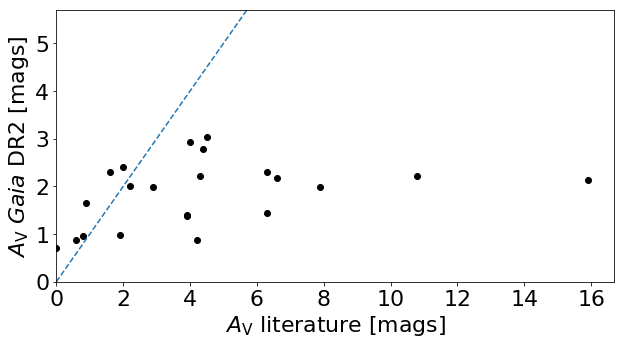

In [9]:
# Compare Literature VS Gaia References ====
merged['source_id'] = [np.int(inp[9:]) for inp in merged['gaia_id']]
combined = join(merged, sample_common['source_id', 'a_g_val'], keys = 'source_id')
combined = combined[combined['a_g_val'].mask == False]
combined['a_g_val'].format = '2.1f'
combined = combined['source_id', 'Ref.', 'Av', 'a_g_val']
combined.rename_column('a_g_val', 'Ag')
combined.write('06_estimate_Av.tex', format = 'ascii.latex', overwrite = True)
!open 06_estimate_Av.tex

# Create plot
fig = plt.figure(figsize=[10,5])
ftsize = 22
plt.xlabel(r'$A_\mathrm{V}$ literature [mags]', fontsize = ftsize)
plt.ylabel(r'$A_\mathrm{V}$ $Gaia$ DR2 [mags]', fontsize = ftsize)
plt.xlim([0, combined['Av'].max() * 1.05])
plt.ylim([0, combined['Ag'].max() * 2])
plt.xticks(fontsize = ftsize)
plt.yticks(fontsize = ftsize)

plt.plot(combined['Av'], combined['Ag']/0.94, 'ko')
plt.plot(np.arange(len(combined)), np.arange(len(combined)), '--')
plt.show()
fig.savefig('06_estimate_Av_0.pdf', bbox_inches = 'tight', overwrite = True)

In [10]:
combined

source_id,Ref.,Av,Ag
,,mag,mag
int64,int64,float32,float32
6046062364938324608,1,4.2,0.8
6047590243721186688,1,4.4,2.6
6049067776894321024,1,3.9,1.3
6049094616145974272,1,6.3,2.2
6049095406419962112,1,7.9,1.9
6049101866050768384,1,2.9,1.9
6049118388788178816,1,4.0,2.8
6049122310095142656,1,1.6,2.2
